try:
    # settings colab:
    import google.colab
except ModuleNotFoundError:    
    # settings local:
    %run "../../../common/0_notebooks_base_setup.py"

---

<img src='../../../common/logo_DH.png' align='left' width=35%/>


## Ejercicios

En esta clase vamos entrenar distintos modelos de clasificación usando:
    
* Regresión Logística    

* KNN

* Classification Tree

* Random Forest


Para cada uno de ello vamos a evaluar la preformance en testing del modelo resultado

* Default

* Grid Search Cross Validation KFold

* Grid Search CV Stratified KFold

* Bagging

* Bagging Grid Search Cross Validation

Las métricas que vamos a calcular para cada modelo son

* score

* confusion matrix




## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import auc, plot_roc_curve


## Ejercicio 1

1.1) Leamos los datos del archivo datasets_222487_478477_framingham.csv

1.2) ¿Qué porcentaje de registros hay en cada una de las categorías target?

1.3) ¿El dataset tiene datos faltantes?

1.4) Usemos `dropna` para eliminar los registros con valores faltantes, y volvamos a calcular el porcentaje de registros hay en cada una de las categorías target 

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html


In [91]:
data_raw = pd.read_csv('midi_stats_new.csv',sep=",")
data_raw.shape

(5139, 168)

In [92]:
data_raw.columns

Index(['Unnamed: 0', 'time_signatures', 'tonalidad', 'tonalidad_escala',
       'scale_coverage', 'mayor_chord_coverage', 'minor_chord_coverage',
       'sc_1', 'sc_2', 'sc_3',
       ...
       'Fiddle', 'Tinkle Bell', 'Bagpipe', 'Cuica', 'Dulcimer/Santur',
       'Woodblock', 'Square', 'Koto', 'Blown Bottle', 'Shamisen'],
      dtype='object', length=168)

Veamos qué procentaje de registros hay en cada una de las categorías target

In [93]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5139 entries, 0 to 5138
Columns: 168 entries, Unnamed: 0 to Shamisen
dtypes: float64(159), int64(2), object(7)
memory usage: 6.6+ MB


In [94]:
data = data_raw.fillna(value=0)
data.shape

(5139, 168)

Vemos que en este caso, eliminando los registros que tienen algun valor nulo no cambiamos la proporción de registros en cada una de las categorías target

In [95]:
data.loc[:,data.dtypes == object].head(1)

,time_signatures,tonalidad,tonalidad_escala,info_tracks,Genero,Grupo,tema
0,['3/4'],F,M,untitled0 1 2 3 4 5,Classical,Bach,01 Menuet


In [96]:
data.drop(['info_tracks','Grupo','tema','time_signatures','Unnamed: 0','cant_pedales_seg'],inplace=True,axis=1)

In [97]:
data.loc[:,data.dtypes == object].head(1)

,tonalidad,tonalidad_escala,Genero
0,F,M,Classical


In [98]:
data = pd.get_dummies(data, columns=['tonalidad','tonalidad_escala'], prefix_sep='_', drop_first=True)

In [99]:
data.loc[:,data.dtypes == object].head(1)

,Genero
0,Classical


In [100]:
data.shape

(5139, 181)

In [78]:
for col in data.loc[:,data.dtypes == np.float64].columns:
    data[col] = data[col].apply(lambda x: round(x,2))

## Ejercicio 2 - Train Test Split + StandardScaler

Construir los conjuntos de entranamiento y test y usando StandardScaler normalizar las features

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [101]:
X=data.drop(["Genero"],axis=1)
y=data["Genero"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=717, stratify=y)

bad_indices = np.where(np.isinf(X))

X.iloc[bad_indices[1][0]].head(50)


In [102]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

## De la práctica de checkpoint:

Vamos a usar esta función para entrenar todos los modelos que pide el enunciado, devolviendo como resultado las métricas de evaluación de cada modelo.

In [103]:
def evaluate_model(model_instance, X_train, y_train, X_test, y_test, gridSearch_params, gridSearch_bagging_params):
    
    # entreno el modelo default
    model_instance.fit(X_train, y_train)
    
    # calculo el score sobre los datos de test
    score_default_test = model_instance.score(X_test, y_test)
    
    # calculo la matriz de confusión
    predictions_default = model_instance.predict(X_test)
    confusion_matrix_default = metrics.confusion_matrix(y_test, predictions_default)
    
    ###################################################
    
    # gridSearch KFold:    
    cv_KFold = KFold(n_splits=3, shuffle=True, random_state=371)
    grid_search_CV_KFold_model = GridSearchCV(model_instance, gridSearch_params, n_jobs=-1, cv = cv_KFold)    
    grid_search_CV_KFold_model.fit(X_train, y_train)        
    scores_KFold = cross_val_score(model_instance, X_train, y_train, cv=cv_KFold, n_jobs=-1)
    mean_score_grid_search_CV_KFold_model = scores_KFold.mean()
    std_score_grid_search_CV_KFold_model = scores_KFold.std()
        
    score_grid_search_CV_KFold_model = grid_search_CV_KFold_model.best_score_
    params_grid_search_CV_KFold_model = grid_search_CV_KFold_model.best_params_
    
    score_grid_search_CV_KFold_model_test = grid_search_CV_KFold_model.score(X_test, y_test)
    predictions_grid_search_CV_KFold_model = grid_search_CV_KFold_model.predict(X_test)    
    confusion_matrix_grid_search_CV_KFold_model = metrics.confusion_matrix(y_test, predictions_grid_search_CV_KFold_model)

    ###################################################
    
    # gridSearch Stratified KFold:    
    cv_Stratified_KFold = StratifiedKFold(n_splits=3, shuffle=True, random_state=371)
    grid_search_CV_Stratified_KFold_model = GridSearchCV(model_instance, gridSearch_params, n_jobs=-1, cv = cv_Stratified_KFold)    
    grid_search_CV_Stratified_KFold_model.fit(X_train, y_train)        
    scores_Stratified_KFold = cross_val_score(model_instance, X_train, y_train, cv=cv_Stratified_KFold, n_jobs=-1)
    mean_score_grid_search_CV_Stratified_KFold_model = scores_Stratified_KFold.mean()
    std_score_grid_search_CV_Stratified_KFold_model = scores_Stratified_KFold.std()    
    
    score_grid_search_CV_Stratified_KFold_model = grid_search_CV_Stratified_KFold_model.best_score_
    params_grid_search_CV_Stratified_KFold_model = grid_search_CV_Stratified_KFold_model.best_params_
    
    score_grid_search_CV_Stratified_KFold_model_test = grid_search_CV_Stratified_KFold_model.score(X_test, y_test)
    predictions_grid_search_CV_Stratified_KFold_model = grid_search_CV_Stratified_KFold_model.predict(X_test)
    confusion_matrix_grid_search_CV_Stratified_KFold_model = metrics.confusion_matrix(y_test, predictions_grid_search_CV_Stratified_KFold_model)

    ###################################################
    
    if gridSearch_bagging_params:

        # bagging

        bagging_model_default = BaggingClassifier(base_estimator = model_instance)
        bagging_model_default.fit(X_train, y_train)
        score_bagging_model_default_test =  bagging_model_default.score(X_test, y_test)
        
        predictions_bagging_model_default = bagging_model_default.predict(X_test)
        confusion_matrix_bagging_model_default = metrics.confusion_matrix(y_test, predictions_bagging_model_default)    

        ###################################################

        # bagging Stratified KFold cross validation usando de base el mejor modelo de gridsearch estratificado
        base_estimator_stratified_grid_search = grid_search_CV_Stratified_KFold_model.best_estimator_
        cv_Stratified_KFold =StratifiedKFold(n_splits=3, shuffle=True, random_state=371)
        grid_search_bagging_model = GridSearchCV(BaggingClassifier(base_estimator = base_estimator_stratified_grid_search),
                               gridSearch_bagging_params, n_jobs=-1, cv = cv_Stratified_KFold)

        grid_search_bagging_model.fit(X_train, y_train)
        
        score_grid_search_bagging_model_test = grid_search_bagging_model.score(X_test, y_test)
        predictions_grid_search_bagging_model = grid_search_bagging_model.predict(X_test)
        confusion_matrix_grid_search_bagging_model = metrics.confusion_matrix(y_test, predictions_grid_search_bagging_model)
        scores_bagging_Stratified_KFold = cross_val_score(BaggingClassifier(base_estimator = base_estimator_stratified_grid_search),
                                                          X_train, y_train, cv=cv_Stratified_KFold, n_jobs=-1)
        mean_score_bagging_grid_search_CV_Stratified_KFold_model = scores_bagging_Stratified_KFold.mean()
        std_score_bagging_grid_search_CV_Stratified_KFold_model = scores_bagging_Stratified_KFold.std()    
        
        best_score_bagging_grid_search_CV_Stratified_KFold_model = grid_search_bagging_model.best_score_
        best_params_bagging_grid_search_CV_Stratified_KFold_model = grid_search_bagging_model.best_params_
    
    else:
        
        score_bagging_model_default_test = None
        confusion_matrix_bagging_model_default = None
        mean_score_bagging_grid_search_CV_Stratified_KFold_model = None
        std_score_bagging_grid_search_CV_Stratified_KFold_model = None
        confusion_matrix_grid_search_bagging_model = None
        best_score_bagging_grid_search_CV_Stratified_KFold_model = None
        score_grid_search_bagging_model_test = None
        best_params_bagging_grid_search_CV_Stratified_KFold_model = None

                                                                                                                                     
    ###################################################
    
    
    # armo un diccionario con todos los valores de performance que calculé para los modelos
    result = {
        'default': {
            'score': score_default_test,
            'confusion_matrix': confusion_matrix_default            
        },
        'cv_kfold': {
            'mean_score_grid_search': mean_score_grid_search_CV_KFold_model,
            'std_score_grid_search': std_score_grid_search_CV_KFold_model,
            'best_score_grid_search': score_grid_search_CV_KFold_model,
            'score': score_grid_search_CV_KFold_model_test,
            'confusion_matrix': confusion_matrix_grid_search_CV_KFold_model           
        },
        'cv_stratified_kfold': {
            'mean_score_grid_search': mean_score_grid_search_CV_Stratified_KFold_model,
            'std_score_grid_search': std_score_grid_search_CV_Stratified_KFold_model,
            'best_score_grid_search': score_grid_search_CV_Stratified_KFold_model,
            'score': score_grid_search_CV_Stratified_KFold_model_test,
            'confusion_matrix': confusion_matrix_grid_search_CV_Stratified_KFold_model           
        },
        'bagging': {
            'score': score_bagging_model_default_test,
            'confusion_matrix': confusion_matrix_bagging_model_default           
        },
        'bagging_cv_stratified_kfold': {
            'mean_score_grid_search': mean_score_bagging_grid_search_CV_Stratified_KFold_model,
            'std_score_grid_search': std_score_bagging_grid_search_CV_Stratified_KFold_model,
            'best_score_grid_search': best_params_bagging_grid_search_CV_Stratified_KFold_model,
            'score': score_grid_search_bagging_model_test,
            'confusion_matrix': confusion_matrix_grid_search_bagging_model           
        }
        
    }
    
    return result
        
#           'trained_model_instance': model_instance, 
#              'score_default': score_default_test,
#              'confusion_matrix_default': confusion_matrix_default,
#              'mean_score_grid_search_CV_KFold_model': mean_score_grid_search_CV_KFold_model, 
#              'std_score_grid_search_CV_KFold_model': std_score_grid_search_CV_KFold_model, 
#              'best_score_grid_search_CV_KFold_model': score_grid_search_CV_KFold_model,
#              'best_params_grid_search_CV_KFold_model': params_grid_search_CV_KFold_model,              
#              'score_grid_search_CV_KFold_model_test': score_grid_search_CV_KFold_model_test,
#              'confusion_matrix_grid_search_CV_KFold_model': confusion_matrix_grid_search_CV_KFold_model,
        
#              'mean_score_grid_search_CV_Stratified_KFold_model': mean_score_grid_search_CV_Stratified_KFold_model, 
#              'std_score_grid_search_CV_Stratified_KFold_model': std_score_grid_search_CV_Stratified_KFold_model, 
#              'best_score_grid_search_CV_Stratified_KFold_model': score_grid_search_CV_Stratified_KFold_model,
#              'best_params_grid_search_CV_Stratified_KFold_model': params_grid_search_CV_Stratified_KFold_model,              
#              'score_grid_search_CV_Stratified_KFold_model_test': score_grid_search_CV_Stratified_KFold_model_test,
#              'confusion_matrix_grid_search_CV_Stratified_KFold_model': confusion_matrix_grid_search_CV_Stratified_KFold_model,
        
#              'score_bagging_default': score_bagging_model_default_test,
#              'confusion_matrix_bagging_default': confusion_matrix_bagging_model_default,
        
#              'mean_score_bagging_grid_search_CV_Stratified_KFold_model': mean_score_bagging_grid_search_CV_Stratified_KFold_model, 
#              'std_score_bagging_grid_search_CV__StratifiedKFold_model': std_score_bagging_grid_search_CV_Stratified_KFold_model, 
#              'best_score_bagging_grid_search_CV_Stratified_KFold_model': best_score_bagging_grid_search_CV_Stratified_KFold_model,
#              'best_params_bagging_grid_search_CV_Stratified_KFold_model': best_params_bagging_grid_search_CV_Stratified_KFold_model,              
#              'score_bagging_grid_search_CV_Stratified_KFold_model_test': score_grid_search_bagging_model_test,
#              'confusion_matrix_bagging_grid_search_CV_Stratified_KFold_model': confusion_matrix_grid_search_bagging_model,

    
    
    
    
    

## Ejercicio 3 - Regresión Logística

Usemos la función definida en el checkpoint que evalua la performance de modelos en un modelo de regresión logística usando `LogisticRegression` con los parámetros por default

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Los parámetros de GridSearchCV que vamos a probar son 

``params = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'penalty': ['l1', 'l2']}``

Los parámetros de bagging que vamos a probar son

<code>
bagging_params = {'n_estimators': [10, 100],

                  'max_samples': [0.01, 1.0],
                  
                  'max_features': [0.3, 1.0],
                  
                  'bootstrap_features': [True, False]}
</code>



In [104]:
model_instance = LogisticRegression()
x_train = X_train_sc
x_test =  X_test_sc
gridSearch_params = {'C': [0, 1e-20, 1e-10, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'penalty': ['l1', 'l2']}
gridSearch_bagging_params = {'n_estimators': [10, 100],
                  'max_samples': [0.01, 1.0],                  
                  'max_features': [0.3, 1.0],                  
                  'bootstrap_features': [True, False]}

logistic_metrics = evaluate_model(model_instance, x_train, y_train, x_test, y_test, gridSearch_params, gridSearch_bagging_params)

logistic_metrics

C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Patricio\anaconda3\envs\dhdsblend\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

{'default': {'score': 0.8372243839169909,
  'confusion_matrix': array([[646,  12,  26,   0,  10,   8,   5,  15,  21],
         [  1, 449,   1,   0,   0,   5,   0,   0,   1],
         [ 26,   0,  16,   0,   4,   1,   1,   1,   3],
         [  0,   0,   0,  98,   0,   0,   0,   0,   0],
         [ 15,   1,   0,   0,   8,   0,   0,   0,   1],
         [ 15,   7,   0,   2,   0,  26,   0,   1,   1],
         [  7,   0,   1,   0,   0,   1,   3,   0,   1],
         [  9,   0,   3,   0,   1,   1,   0,   3,   1],
         [ 34,   1,   1,   0,   2,   3,   0,   1,  42]], dtype=int64)},
 'cv_kfold': {'mean_score_grid_search': 0.8348623853211009,
  'std_score_grid_search': 0.00557407218675659,
  'best_score_grid_search': 0.8518209619127051,
  'score': 0.8527885862516212,
  'confusion_matrix': array([[671,  15,  20,   0,   5,   7,   1,   7,  17],
         [  2, 453,   0,   0,   0,   2,   0,   0,   0],
         [ 28,   0,  18,   0,   0,   0,   1,   3,   2],
         [  0,   0,   0,  98,   0,   0,   0

(Para todos los modelos vamos a ver que la capacidad de predicción de la clase minoritaria es bastante mala)

## Ejercicio 4 - KNN

Usemos la función definida en el checkpoint que evalua la performance de modelos en un modelo KNN usando `KNeighborsClassifier` con los parámetros por default (n_neighbors=5)

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Los parámetros de GridSearchCV que vamos a probar son 

``params =  {'n_neighbors': range(1,50)}``

Los parámetros de bagging que vamos a probar son

<code>
bagging_params = {'n_estimators': [10, 100],

                  'max_samples': [0.05, 1.0],
                  
                  'max_features': [0.3, 1.0],
                  
                  'bootstrap_features': [True, False]}
</code>



In [105]:
model_instance = KNeighborsClassifier()
x_train = X_train_sc
x_test =  X_test_sc
gridSearch_params = {'n_neighbors': range(1,50)}
gridSearch_bagging_params = {'n_estimators': [10, 100],
                  'max_samples': [0.05, 1.0],                  
                  'max_features': [0.3, 1.0],                  
                  'bootstrap_features': [True, False]}

knn_metrics = evaluate_model(model_instance, x_train, y_train, x_test, y_test, gridSearch_params, gridSearch_bagging_params)

knn_metrics

{'default': {'score': 0.7931258106355382,
  'confusion_matrix': array([[643,  62,   5,  11,   8,   6,   0,   1,   7],
         [  8, 446,   0,   1,   0,   2,   0,   0,   0],
         [ 41,   1,   5,   0,   1,   3,   0,   0,   1],
         [  0,   0,   0,  98,   0,   0,   0,   0,   0],
         [ 16,   2,   0,   0,   4,   1,   0,   0,   2],
         [ 20,  20,   0,   2,   0,  10,   0,   0,   0],
         [ 11,   1,   0,   0,   0,   0,   0,   0,   1],
         [ 16,   0,   1,   0,   0,   0,   0,   0,   1],
         [ 56,   8,   0,   0,   0,   2,   0,   1,  17]], dtype=int64)},
 'cv_kfold': {'mean_score_grid_search': 0.7939949958298582,
  'std_score_grid_search': 0.00557407218675659,
  'best_score_grid_search': 0.7939949958298582,
  'score': 0.7931258106355382,
  'confusion_matrix': array([[643,  62,   5,  11,   8,   6,   0,   1,   7],
         [  8, 446,   0,   1,   0,   2,   0,   0,   0],
         [ 41,   1,   5,   0,   1,   3,   0,   0,   1],
         [  0,   0,   0,  98,   0,   0,   0

## Ejercicio 5 - Tree

Usemos la función definida en el checkpoint que evalua la performance de modelos en un modelo de árbol de decisión usando `DecisionTreeClassifier` con los parámetros por default

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

Los parámetros de GridSearchCV que vamos a probar son 

``params =  {'criterion': ['gini', 'entropy'],
          'splitter': ['best', 'random'],
          'max_depth': [None, 5, 10],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 2, 3]}``

Los parámetros de bagging que vamos a probar son

<code>
bagging_params = {'n_estimators': [10, 100],

                  'max_samples': [0.01, 1.0],
                  
                  'max_features': [0.3, 1.0],
                  
                  'bootstrap_features': [True, False]}
</code>


In [106]:
model_instance = DecisionTreeClassifier()
x_train = X_train_sc
x_test =  X_test_sc
gridSearch_params = {'criterion': ['gini', 'entropy'],
          'splitter': ['best', 'random'],
          'max_depth': [None, 5, 10],
          'min_samples_split': [2, 5],
          'min_samples_leaf': [1, 2, 3]}

gridSearch_bagging_params = {'n_estimators': [10, 100],
                  'max_samples': [0.01, 1.0],                  
                  'max_features': [0.3, 1.0],                  
                  'bootstrap_features': [True, False]}

decision_tree_metrics = evaluate_model(model_instance, x_train, y_train, x_test, y_test, gridSearch_params, gridSearch_bagging_params)

decision_tree_metrics

{'default': {'score': 0.8106355382619974,
  'confusion_matrix': array([[614,  14,  40,   0,  12,  13,   9,  12,  29],
         [  6, 448,   0,   1,   1,   0,   0,   0,   1],
         [ 16,   0,  22,   0,   1,   1,   1,   1,  10],
         [  0,   2,   0,  96,   0,   0,   0,   0,   0],
         [ 10,   1,   0,   0,   6,   1,   0,   1,   6],
         [ 16,   8,   0,   1,   2,  23,   0,   0,   2],
         [  6,   0,   0,   0,   0,   1,   1,   0,   5],
         [ 11,   0,   4,   0,   0,   0,   0,   3,   0],
         [ 34,   2,   4,   0,   1,   3,   1,   2,  37]], dtype=int64)},
 'cv_kfold': {'mean_score_grid_search': 0.8042813455657493,
  'std_score_grid_search': 0.0068888027208027945,
  'best_score_grid_search': 0.8454267445093134,
  'score': 0.8365758754863813,
  'confusion_matrix': array([[695,  17,  15,   0,   0,   3,   0,   0,  13],
         [  1, 456,   0,   0,   0,   0,   0,   0,   0],
         [ 32,   0,  17,   0,   0,   0,   0,   1,   2],
         [  0,   3,   0,  95,   0,   0,  

## Ejercicio 6 - Random Forest

Usemos la función definida en el checkpoint que evalua la performance de modelos en un modelo random forest usando `RandomForestClassifier` con los parámetros por default

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Los parámetros de GridSearchCV que vamos a probar son 

``params =   {'n_estimators':[3, 5, 10, 50],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}``

(No vamos a hacer bagging sobre este modelo porque ya es un ensamble.)

In [107]:
model_instance = RandomForestClassifier()
x_train = X_train_sc
x_test =  X_test_sc
gridSearch_params = {'n_estimators':[3, 5, 10, 50],
          'criterion': ['gini', 'entropy'],
          'max_depth': [None, 3, 5],
          'min_samples_split': [2,5],
          'class_weight':[None, 'balanced']}

gridSearch_bagging_params = None

random_forest_metrics = evaluate_model(model_instance, x_train, y_train, x_test, y_test, gridSearch_params, gridSearch_bagging_params)

random_forest_metrics

{'default': {'score': 0.851491569390402,
  'confusion_matrix': array([[719,  16,   7,   0,   1,   0,   0,   0,   0],
         [  1, 456,   0,   0,   0,   0,   0,   0,   0],
         [ 46,   0,   6,   0,   0,   0,   0,   0,   0],
         [  0,   0,   0,  98,   0,   0,   0,   0,   0],
         [ 21,   3,   0,   0,   0,   0,   0,   0,   1],
         [ 19,  16,   0,   0,   0,  17,   0,   0,   0],
         [ 13,   0,   0,   0,   0,   0,   0,   0,   0],
         [ 16,   0,   1,   0,   0,   0,   0,   1,   0],
         [ 65,   2,   0,   0,   0,   1,   0,   0,  16]], dtype=int64)},
 'cv_kfold': {'mean_score_grid_search': 0.8582151793160967,
  'std_score_grid_search': 0.007674269525628198,
  'best_score_grid_search': 0.8607172643869893,
  'score': 0.8586251621271076,
  'confusion_matrix': array([[712,  17,   8,   0,   2,   0,   0,   0,   4],
         [  1, 455,   0,   0,   0,   1,   0,   0,   0],
         [ 39,   0,  10,   0,   0,   0,   0,   0,   3],
         [  0,   0,   0,  98,   0,   0,   0

## Ejercicio 7 - Evaluación de modelos

Vamos a comparar los resultados de los diferentes modelos. Para eso, grafiquemos como barras los scores de los modelos evaluados en el conjunto de testing. 

¿Cuál es el ganador?

Repetir el gráfico mostrando el valor medio el desvío estandard de la validación cruzada. ¿Es el mismo ganador?


In [108]:
all_model_metrics = [logistic_metrics, knn_metrics, decision_tree_metrics, random_forest_metrics]
all_model_names =  ['logistic', 'knn', 'decision_tree', 'random_forest']

data_to_plot = pd.DataFrame(columns = ['model', 'score'])
data_to_plot

for i in range(len(all_model_names)):
    model_name_prefix = all_model_names[i]
    model_metric = all_model_metrics[i]        
    for model_metric_key in model_metric.keys():    
        score = model_metric[model_metric_key]['score']        
        data_to_plot = data_to_plot.append({'model': model_name_prefix + '_' + model_metric_key, 'score':score}, ignore_index=True)
        
data_to_plot.index = data_to_plot.model

data_to_plot.sort_values(by = 'score', axis=0, ascending=True, inplace=True)


(0.7, 0.9)

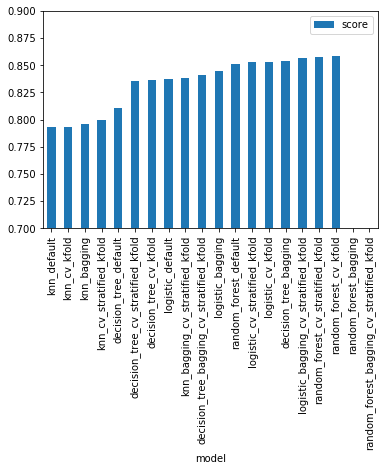

In [109]:
data_to_plot.plot(kind='bar')
plt.ylim(0.7, 0.9)


In [110]:
data_to_plot_cv = pd.DataFrame(columns = ['model', 'score', 'error'])

for i in range(len(all_model_names)):
    model_name_prefix = all_model_names[i]
    model_metric = all_model_metrics[i]        
    for model_metric_key in model_metric.keys():    
        model = model_metric[model_metric_key]
        if 'mean_score_grid_search' in model.keys() and 'std_score_grid_search' in model.keys():
            score = model['mean_score_grid_search']        
            std = model['std_score_grid_search']        
            data_to_plot_cv = data_to_plot_cv.append({'model': model_name_prefix + '_' + model_metric_key, 
                                            'score':score,
                                            'error': std,
                                           }, ignore_index=True)
        
data_to_plot_cv.index = data_to_plot_cv.model

data_to_plot_cv.sort_values(by = 'score', axis=0, ascending=True, inplace=True)

In [111]:
data_to_plot_cv

,model,score,error
model,,,
knn_bagging_cv_stratified_kfold,knn_bagging_cv_stratified_kfold,0.783709,0.006141
knn_cv_kfold,knn_cv_kfold,0.793995,0.005574
knn_cv_stratified_kfold,knn_cv_stratified_kfold,0.797887,0.008181
decision_tree_cv_kfold,decision_tree_cv_kfold,0.804281,0.006889
decision_tree_cv_stratified_kfold,decision_tree_cv_stratified_kfold,0.808451,0.006141
logistic_cv_kfold,logistic_cv_kfold,0.834862,0.005574
logistic_cv_stratified_kfold,logistic_cv_stratified_kfold,0.839867,0.007077
decision_tree_bagging_cv_stratified_kfold,decision_tree_bagging_cv_stratified_kfold,0.840701,0.007366
logistic_bagging_cv_stratified_kfold,logistic_bagging_cv_stratified_kfold,0.858215,0.007853


(0.7, 0.9)

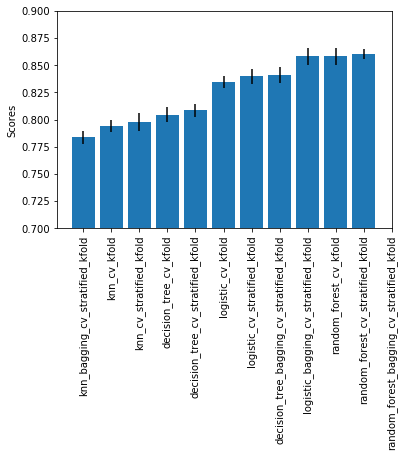

In [112]:
fig, ax = plt.subplots()
x_values = range(data_to_plot_cv.shape[0])
y_values = data_to_plot_cv.score
rects1 = ax.bar(x_values, y_values,
                yerr=data_to_plot_cv.error,
                tick_label=data_to_plot_cv.index)

ax.set_ylabel('Scores')
plt.xticks(rotation=90)
plt.ylim(0.7, 0.9)

In [113]:
y_values

model
knn_bagging_cv_stratified_kfold              0.783709
knn_cv_kfold                                 0.793995
knn_cv_stratified_kfold                      0.797887
decision_tree_cv_kfold                       0.804281
decision_tree_cv_stratified_kfold            0.808451
logistic_cv_kfold                            0.834862
logistic_cv_stratified_kfold                 0.839867
decision_tree_bagging_cv_stratified_kfold    0.840701
logistic_bagging_cv_stratified_kfold         0.858215
random_forest_cv_kfold                       0.858215
random_forest_cv_stratified_kfold            0.860161
random_forest_bagging_cv_stratified_kfold         NaN
Name: score, dtype: float64

## Ejercicio 8 - Importancia de features

Veamos ahora la cuál es la importancia de cada variable predictora en el modelo random forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_

Representemos en un gráfico de barras la importancia de cada una, y su error definido como el desvío estandar de las importancias de cada variable sobre todos los árboles.


In [114]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train_sc, y_train)
feature_importance = random_forest.feature_importances_
feature_importance

array([2.18036425e-02, 1.40307435e-02, 7.84433595e-03, 2.22029336e-02,
       8.63473425e-03, 5.93383590e-03, 6.24185044e-03, 5.86291547e-03,
       6.18580300e-03, 9.27533291e-03, 1.83280216e-02, 1.89731268e-02,
       2.16258288e-02, 2.24880591e-02, 1.19294804e-02, 1.67738752e-02,
       1.65643358e-02, 1.98794698e-02, 7.56854046e-03, 6.58825687e-03,
       9.50685057e-03, 1.52678857e-02, 1.60693036e-02, 1.17538672e-02,
       6.61854949e-03, 2.68686427e-03, 1.56228895e-03, 3.34569570e-03,
       2.13006018e-03, 1.37080269e-02, 7.81412028e-03, 1.29227227e-02,
       1.46032567e-02, 1.15620634e-02, 1.38319865e-02, 8.09635491e-03,
       5.28783262e-03, 1.65810513e-02, 6.25742967e-03, 9.32061167e-03,
       9.02519755e-03, 9.89677396e-03, 5.95131762e-03, 4.61817267e-03,
       5.62117788e-03, 4.45402953e-03, 8.77676030e-03, 2.10704092e-03,
       2.95491737e-04, 5.35141443e-04, 7.72844315e-04, 4.49100822e-04,
       3.80625737e-04, 6.17889178e-04, 1.41931908e-04, 1.69078085e-04,
      

In [115]:
# error:
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)
std

array([1.77245244e-02, 1.63441358e-02, 5.71802398e-03, 2.34617949e-02,
       8.60835237e-03, 3.53105474e-03, 3.19044910e-03, 4.23008092e-03,
       3.53149018e-03, 8.30195302e-03, 1.81748996e-02, 3.25776365e-02,
       3.26887469e-02, 2.56718101e-02, 1.94260031e-02, 2.07952734e-02,
       2.15315900e-02, 3.71007179e-02, 1.21526527e-02, 6.97734691e-03,
       1.14188853e-02, 1.76364096e-02, 2.09760017e-02, 1.56261382e-02,
       2.01831089e-02, 7.11513455e-03, 1.47515713e-03, 7.95761340e-03,
       1.65858484e-03, 2.07318345e-02, 5.54109952e-03, 2.20379639e-02,
       2.74485682e-02, 2.02088502e-02, 1.92823043e-02, 1.00876089e-02,
       3.86865404e-03, 2.54241414e-02, 9.05084133e-03, 1.55320587e-02,
       1.25730446e-02, 2.10216693e-02, 8.96853552e-03, 2.32392781e-03,
       2.95799621e-03, 2.67899271e-03, 1.28260725e-02, 6.26739771e-03,
       6.87708420e-04, 8.47658895e-04, 1.14219206e-03, 7.81443547e-04,
       7.59488824e-04, 1.07186935e-03, 3.90007357e-04, 4.54107275e-04,
      

In [116]:
feature_names = data.columns

data_to_plot = pd.DataFrame(columns = ['feature', 'importance', 'error'])

for i in range(len(feature_importance)):
    data_to_plot = data_to_plot.append({'feature': feature_names[i],
                                        'importance': feature_importance[i],
                                        'error': std[i]
                                       }, ignore_index=True)    

data_to_plot.sort_values(by = 'importance', axis=0, ascending=False, inplace=True)
data_to_plot

,feature,importance,error
90,Triangle,0.077738,0.100189
94,Muted Trumpet,0.073374,0.099272
101,Marimba,0.040494,0.073339
91,Drum,0.036313,0.061939
87,ride,0.030057,0.060540
...,...,...,...
160,tonalidad_A#,0.000000,0.000000
168,tonalidad_D#,0.000000,0.000000
171,tonalidad_E,0.000000,0.000000
174,tonalidad_F#,0.000000,0.000000


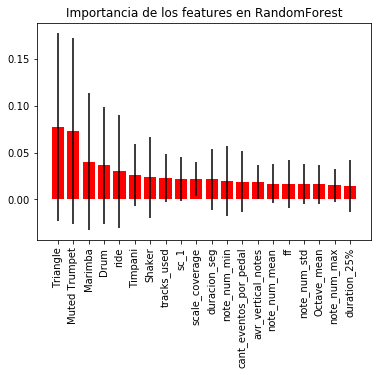

In [124]:
data_to_plot_top = data_to_plot.head(20)

plt.figure()
plt.title("Importancia de los features en RandomForest")
x_values = range(data_to_plot_top.shape[0])
y_values = data_to_plot_top.importance
y_err = data_to_plot_top.error
plt.bar(x_values, y_values, color="r", align="center", yerr=y_err )
plt.xticks(x_values, data_to_plot_top.feature, rotation=90)
plt.show()

In [123]:
data_to_plot.head(40)

,feature,importance,error
90,Triangle,0.077738,0.100189
94,Muted Trumpet,0.073374,0.099272
101,Marimba,0.040494,0.073339
91,Drum,0.036313,0.061939
87,ride,0.030057,0.060540
76,Timpani,0.026098,0.032963
109,Shaker,0.023684,0.043180
13,tracks_used,0.022488,0.025672
3,sc_1,0.022203,0.023462
0,scale_coverage,0.021804,0.017725


## Referencias 

Cross Validation
https://scikit-learn.org/stable/modules/cross_validation.html

StratifiedKFold
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold

Grid Search
https://scikit-learn.org/stable/modules/grid_search.html#grid-search

ROC
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

BaggingClassifier
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
